## 0.0 Imports

In [73]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [2]:
'''
!pip install inflection
!pip install category_encoders

'''

'\n!pip install inflection\n'

### 0.1 Helper Functions

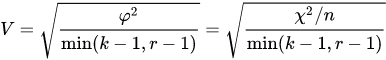

In [3]:
def cramer_v(x,y):
    #crio uma matriz de confusão com as variaveis categoricas
    cm = pd.crosstab(x, y).to_numpy()
    #somatorio das observações
    n = cm.sum()
    
    #linhas e colunas da matriz de confusao
    r, k = cm.shape
    
    #crio o valor do chi2 utilizando recebendo o resultado do teste baseado no metodo de pearson
    chi2 = stats.chi2_contingency(cm)[0]
    
    #CORRIGINDO O VIES DO V DE CRAMER
    chi2corr = max(0, chi2 - ((k-1)*(r-1))/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    #v de cramer
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

### 0.2 Load Data

In [4]:
#low_memory le o arquivo inteiro e não por pedaços
df_sales_raw = pd.read_csv('./data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('./data/store.csv', low_memory=False)

#merge dos dataframes(defino o df de referencia, o que sera acrescentado, o modo de operação e a coluna referencia)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.0 Descrição dos dados

In [6]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#utilizo o inflection para aplicar o snake_case nos nomes das colunas
snkcase = lambda x: inflection.underscore( x )
cols_new = list(map(snkcase, cols_old))

# rename columns
df1.columns = cols_new

### 1.2 Data Dimensions

In [9]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


### 1.3 Data Types

In [10]:
#mudo o tipo da coluna date de object para o tipo datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
836814,235,2,2013-06-11,4792,467,1,0,0,0,a,a,5710.0,3.0,2012.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"


In [14]:
# competition_distance
# a ausencia de dados pode significar uma grande distancia entre os concorrentes, logo aplico nesses dados faltantes 
# um numero maior que a distancia maxima encontrada.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
#a ausencia de dados pode significar que o concorrente abriu depois da abertura da loja
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week
#ausencia de dados pode significar que a loja 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
# promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval
month_map = {1:'Jan',
             2:'Feb',
             3:'Mar',
             4:'Apr',
             5:'May',
             6:'Jun',
             7:'Jul',
             8:'Aug',
             9:'Sep',
             10:'Oct',
             11:'Nov',
             12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
dtype: int64

In [16]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [17]:
df1.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### 1.6 Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7 Descriptive Statistical

In [21]:
num_att = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_att = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

In [22]:
num_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   sales                         1017209 non-null  int64  
 3   customers                     1017209 non-null  int64  
 4   open                          1017209 non-null  int64  
 5   promo                         1017209 non-null  int64  
 6   school_holiday                1017209 non-null  int64  
 7   competition_distance          1017209 non-null  float64
 8   competition_open_since_month  1017209 non-null  int32  
 9   competition_open_since_year   1017209 non-null  int32  
 10  promo2                        1017209 non-null  int64  
 11  promo2_since_week             1017209 non-null  int32  
 12  promo2_since_year           

#### 1.7.1 Numerical Attributes

In [23]:
#tendencia central - media e mediana
ct1 = pd.DataFrame(num_att.apply(np.mean)).T
ct2 = pd.DataFrame(num_att.apply(np.median)).T

#dispersao - desvio padrao, minimo, max, range, skew e kurtosis
d1 = pd.DataFrame(num_att.apply(np.std)).T
d2 = pd.DataFrame(num_att.apply(min)).T
d3 = pd.DataFrame(num_att.apply(max)).T
d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

#concatenação
metrics = pd.concat([d2, d3,d4, ct1, ct2, d1, d5,d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [24]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [25]:
sns.set(rc={'figure.figsize':(15,8)})


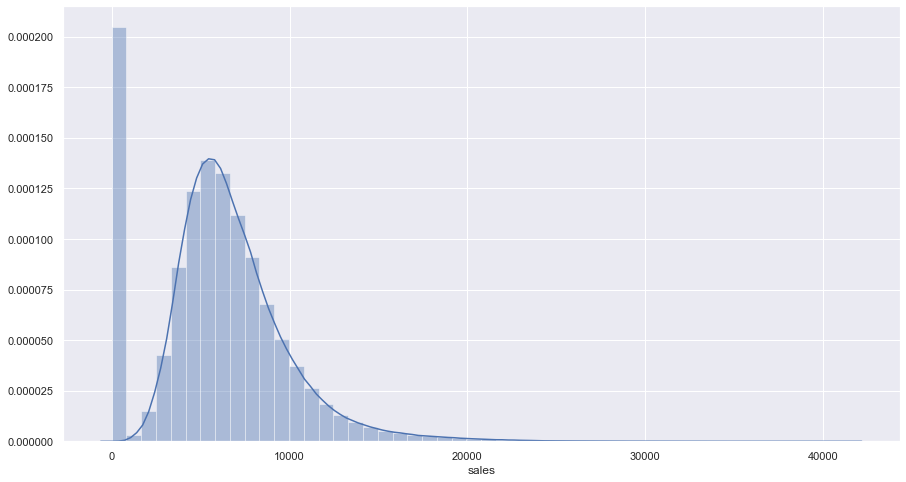

In [26]:
sns.distplot(df1['sales'])

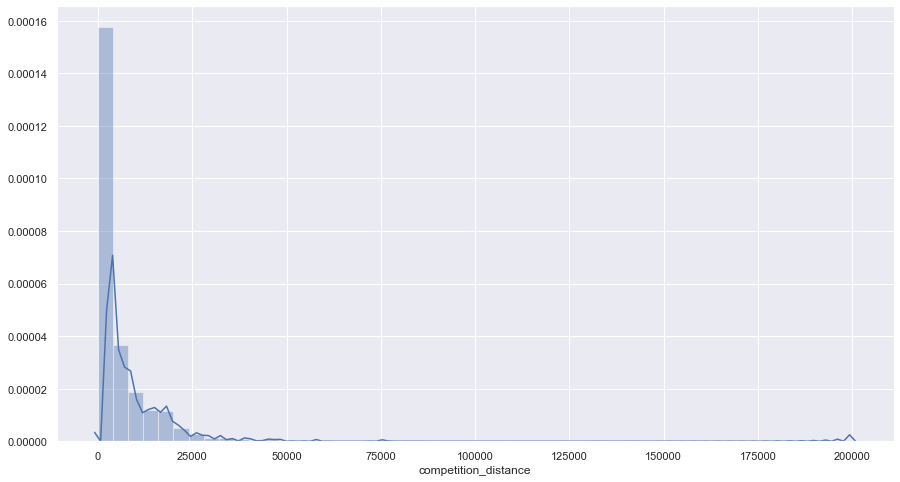

In [27]:
sns.distplot(df1['competition_distance'])

#### 1.7.2 Categorial Attributes

In [28]:
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

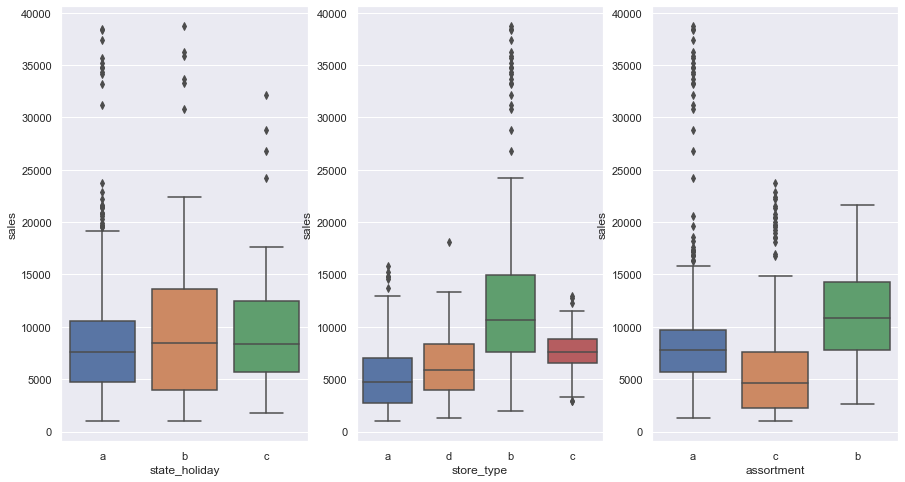

In [29]:
#realizo um filtro do df para trazer somente as vendas em feriados e com vendas
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']>0)]
plt.subplot(1, 3 ,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3 ,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3 ,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [30]:
df2 = df1.copy()

### 2.1 Hypothesis 

#### 2.1.1 Loja

 **1.** lojas com maior sortimento vendem mais 

 **2.** lojas com competidores mais proximos vendem menos

 **3.** lojas com competidores mais distantes vendem mais

#### 2.1.2 Produto


**1.** lojas com promoções continuas vendem mais

**2.** lojas com mais tempo de promoção vendem mais



#### 2.1.3 Sacionalidade 


**1.** lojas em feriados vendem mais

**2.** lojas vendem mais com o passar dos anos

**3.** lojas com datas de pagamento vendem mais



### 2.2 Feature Engineering

In [31]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competion since(mantenho a granularidade em mensal)
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

#promo since 
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
#a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')
#state holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')

In [32]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [33]:
df3 = df2.copy()

In [34]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtragem das linhas

In [35]:
df3  = df3[(df3['open'] != 0)  & (df3['sales'] > 0)]

### 3.2 Selecao das colunas

In [36]:
cols_drop = ['customers', 'open' , 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [37]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise exploratoria de dados

In [38]:
df4 = df3.copy()

### 4.1 Analise Univariada

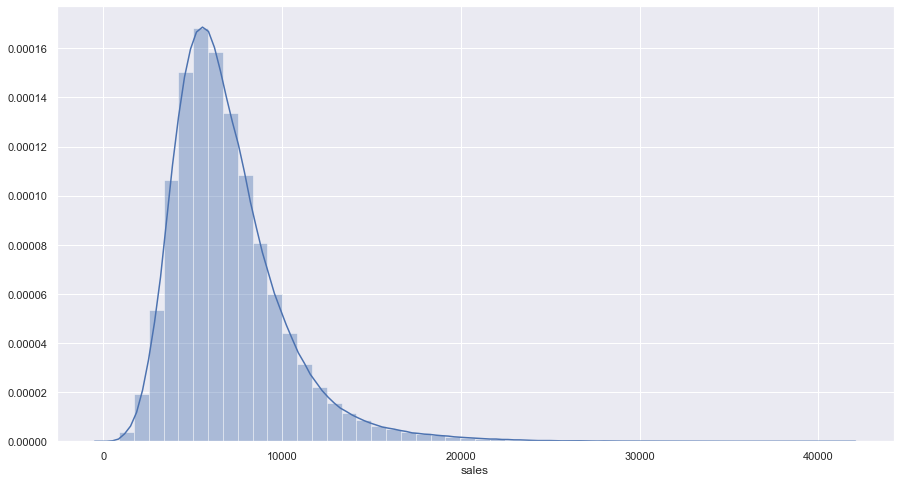

In [39]:
# response variable
sns.distplot(df4['sales'])

<ipython-input-40-067bb5d1da45>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_att.hist(ax=ax,bins=25);


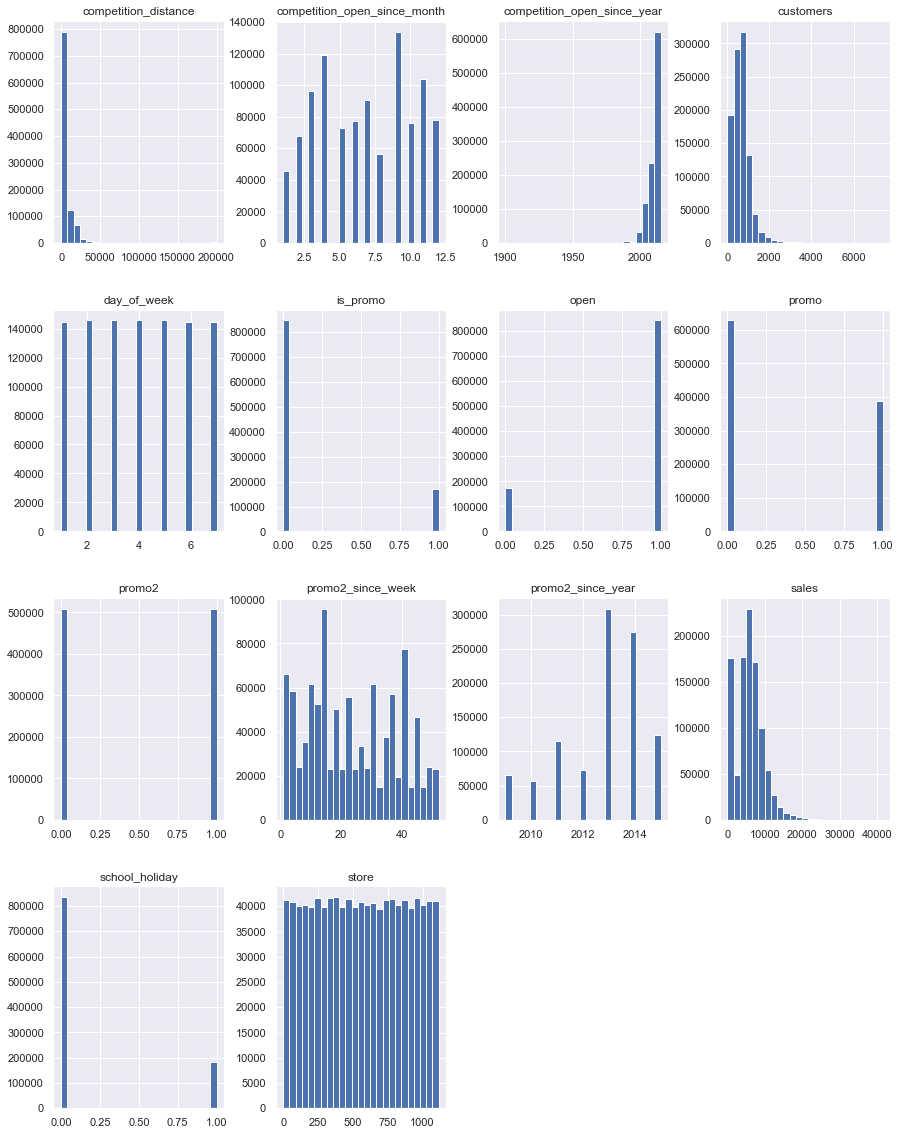

In [40]:
#variaveis numericas
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
num_att.hist(ax=ax,bins=25);

In [41]:
#variaveis categoricas
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

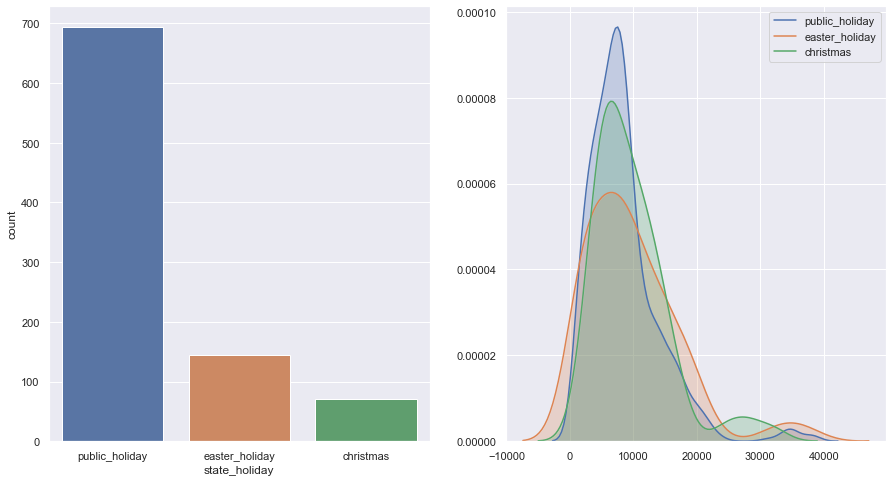

In [42]:
#verifico quais feriados tem mais vendas
#state_holiday
plt.subplot(1,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
#store_type



In [43]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

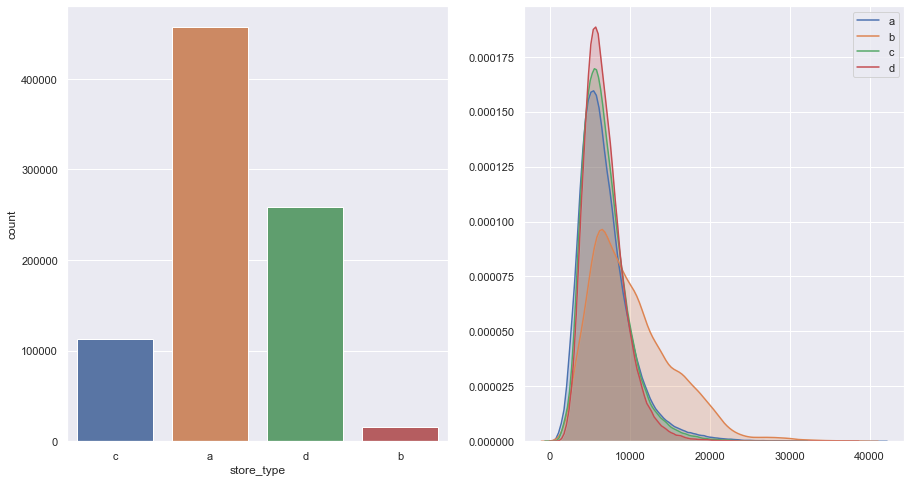

In [44]:
#store_type
plt.subplot(1,2,1)
sns.countplot(df4['store_type'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

In [45]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

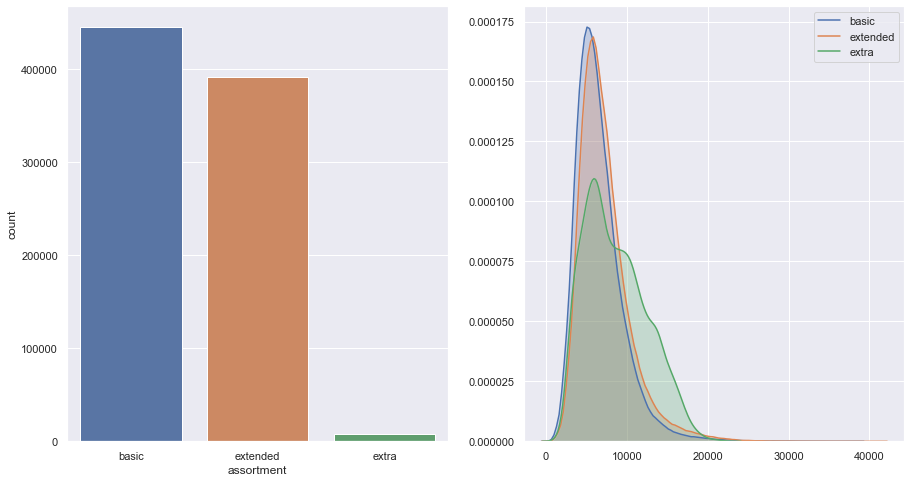

In [46]:
#assortment
plt.subplot(1,2,1)
sns.countplot(df4['assortment'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


### 4.1 Analise Bivariada

**H1. Lojas com maiores sortimentos vendem mais?(verificar qtd de lojas de cada tipo)**

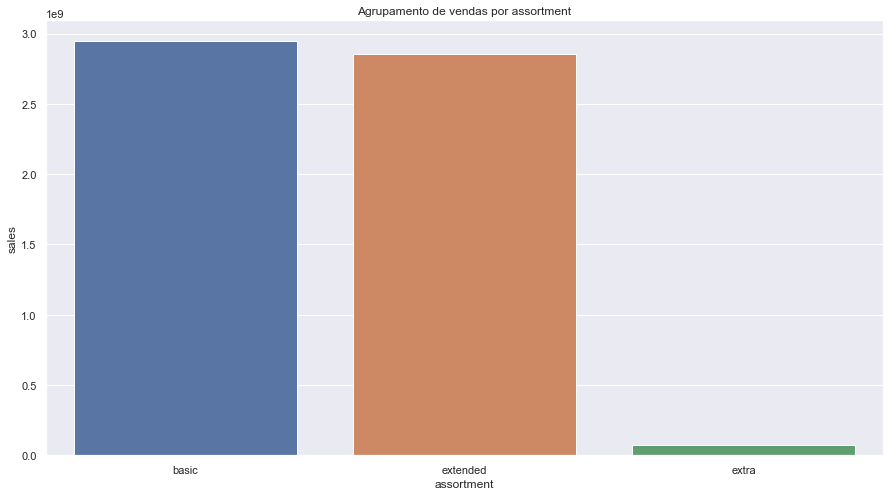

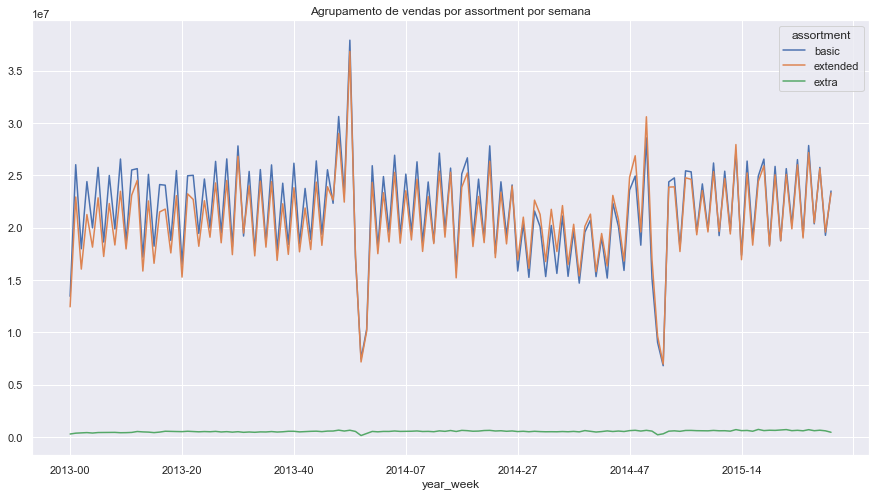

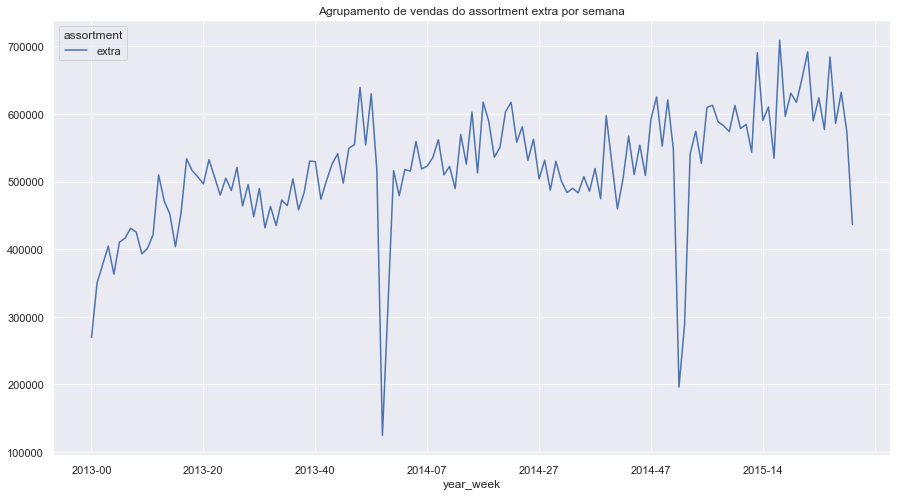

In [47]:
#agrupo os tipos de assortment e somo a quantidade de vendas de cada tipo
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1).set_title('Agrupamento de vendas por assortment')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot().set_title('Agrupamento de vendas por assortment por semana');

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot().set_title('Agrupamento de vendas do assortment extra por semana');

**H2. Lojas com competidores mais proximos vendem menos**
 FALSA

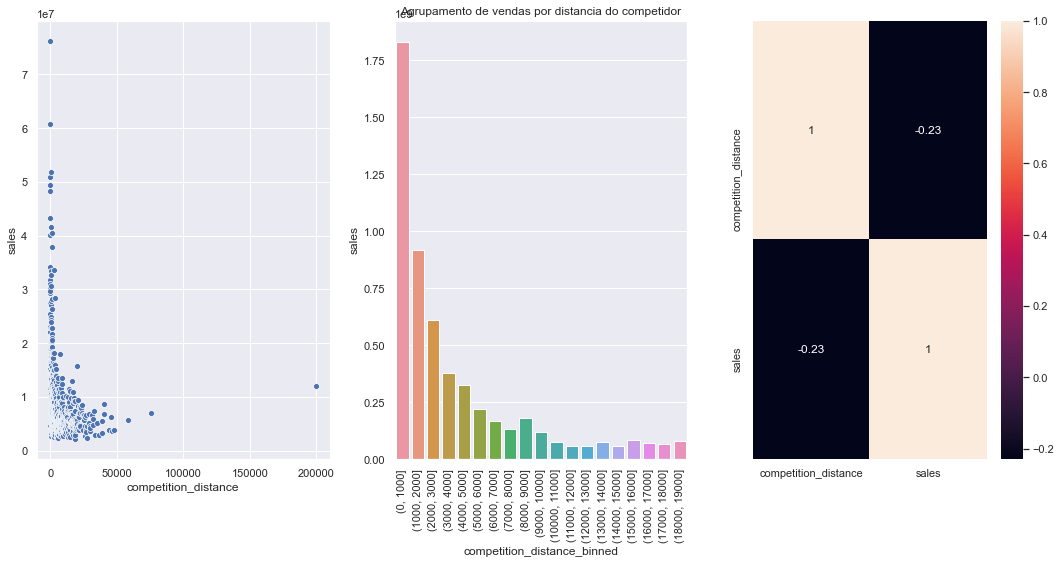

In [48]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3, 1)
sns.scatterplot(x ='competition_distance', y='sales', data=aux1)
#crio uma lista de ultimo elemento como 20000, sempre pulando de 1000 em 1000
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2).set_title('Agrupamento de vendas por distancia do competidor');
plt.xticks(rotation = 90)


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.tight_layout()

**H2. Lojas com competidores à mais tempo vendem mais**
Falsa pois lojas com competidores a mais tempo vendem MENOS

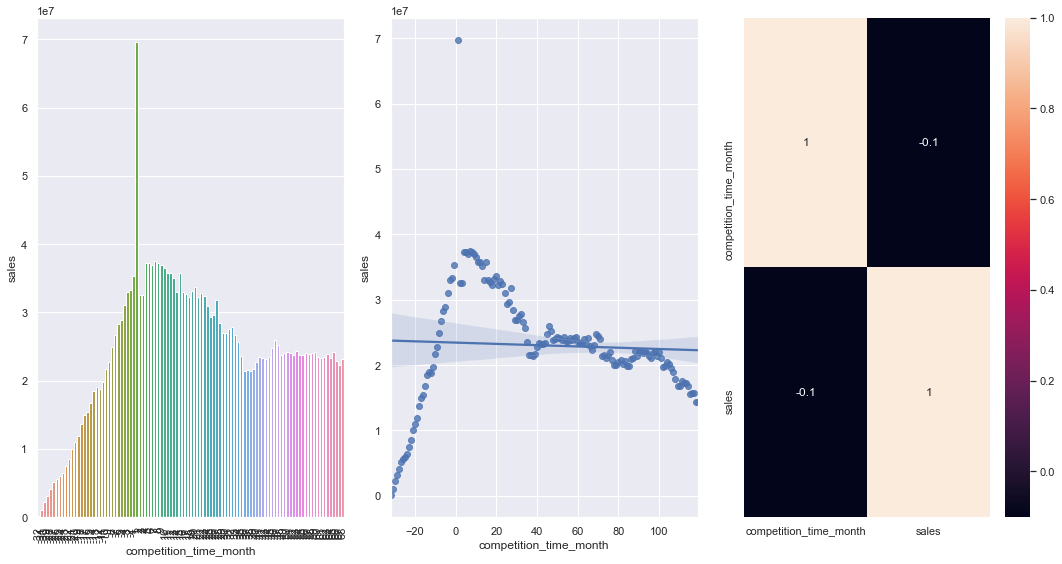

In [49]:
#quanto mais proximo de 0 o resultado de y, maior a quantidade de vendas
plt.subplot(1,3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2, order=aux2['competition_time_month'][:100]);
plt.xticks(rotation=90);

plt.subplot(1,3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.tight_layout()

In [50]:
aux2['competition_time_month'][:100]

0     -32
1     -31
2     -30
3     -29
4     -28
       ..
96     64
97     65
98     66
99     67
100    68
Name: competition_time_month, Length: 100, dtype: int64

### 4.2 Analise multivariada

#### 4.2.1 Variaveis Númericas

In [51]:
num_att.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


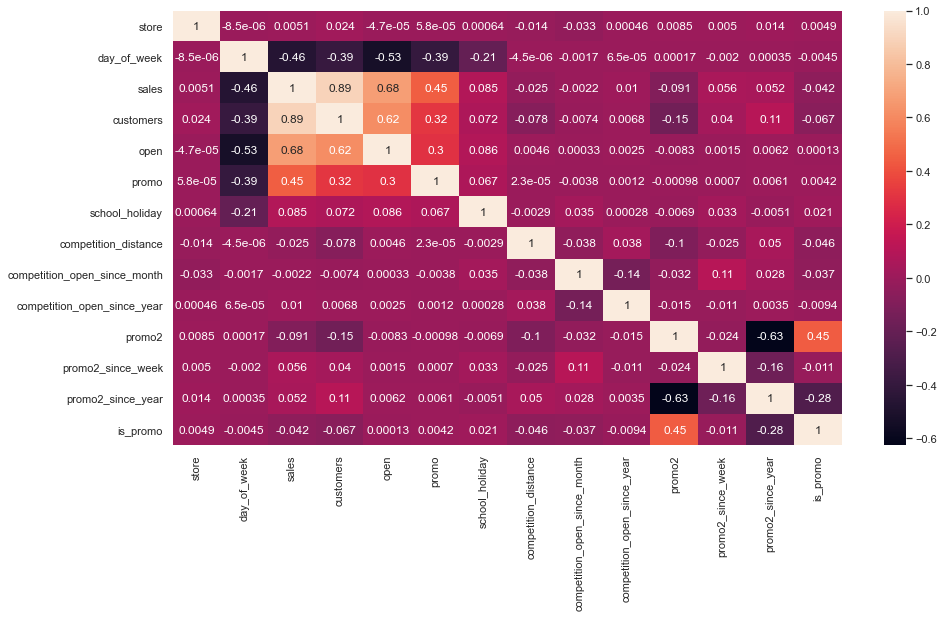

In [52]:
correlation = num_att.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#### 4.2.1 Variaveis Categoricas


In [53]:
a = df4.select_dtypes(include='object')

In [54]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [55]:
#organizo as correlações
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

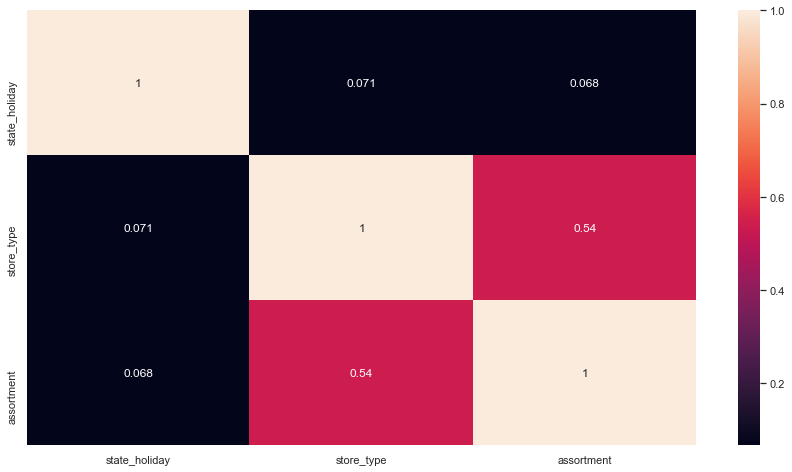

In [56]:
sns.heatmap(d, annot=True)

# 5.0 Preparação dos dados - Feature Transformation

<p> Afim de evitar que os dados sejam viesados, devido a grande dispersão de algumas medidas estatisticas, será aplicado técnicas de preparo dos dados</p>

In [57]:
df5 = df4.copy()

### 5.1 Normalização dos dados

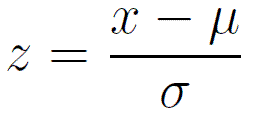

<p>Devido a falta de variaveis que possuam uma distribuição normal, não é utilizado a normalização dos dados </p>

### 5.2 Padronização dos dados - Robust Scalling

<p>Pelo fato de o range de algumas features ser muito discrepante, os algoritmos podem realizar inviezar o modelo
sendo necessario aplicar os dados em uma escala </p>

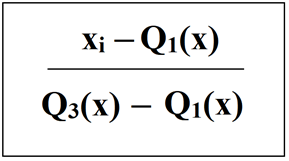

In [58]:
#seleciono tudo que é numerico
a = df5.select_dtypes(exclude=['object', 'datetime64[ns]'])

In [59]:
a.head()


,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


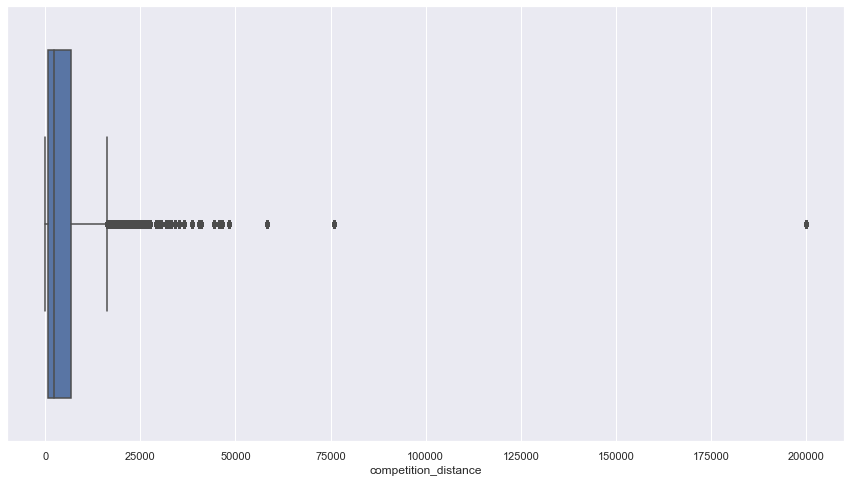

In [60]:
#verifico os outliers da variavel competition distance
sns.boxplot(df5['competition_distance'])

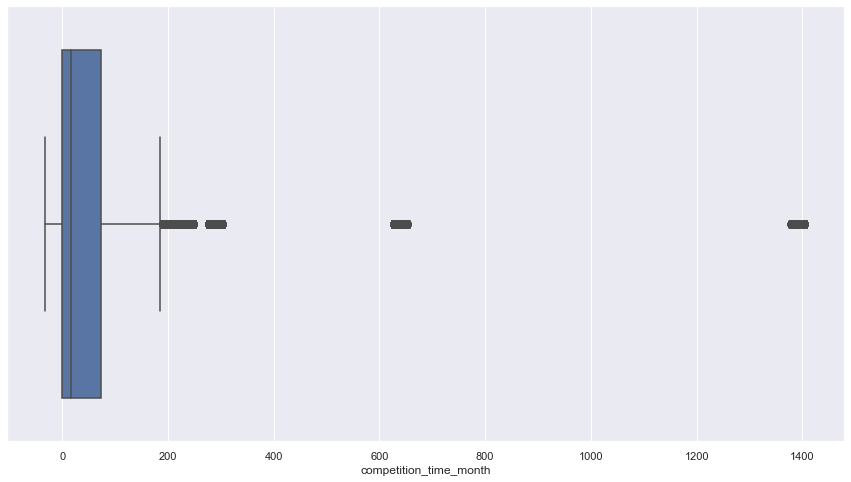

In [61]:
sns.boxplot(df5['competition_time_month'])

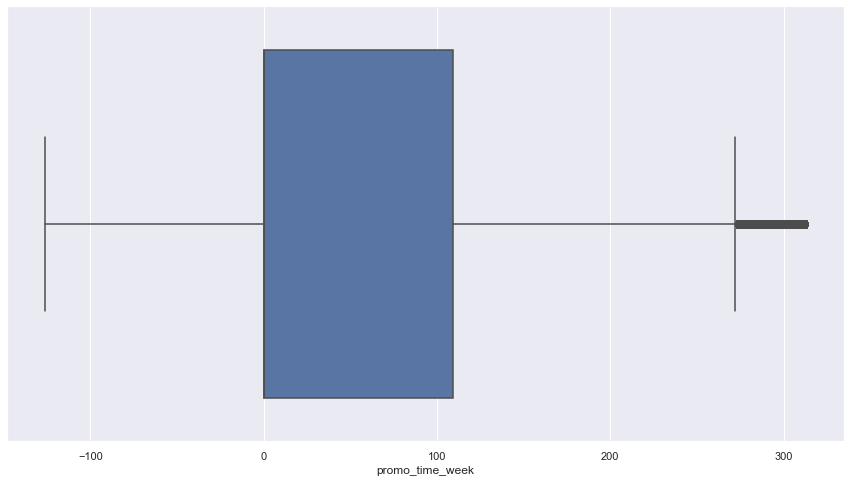

In [62]:
sns.boxplot(df5['promo_time_week'])

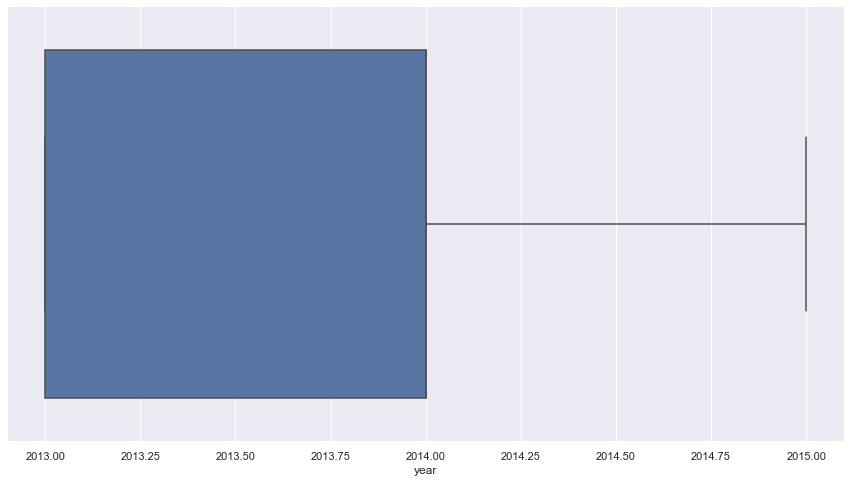

In [63]:
sns.boxplot(df5['year'])

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week(como nao possui muitos outliers importantes, usarei o min max scaler)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
#year
df5['year'] = mms.fit_transform(df5[['year']].values)


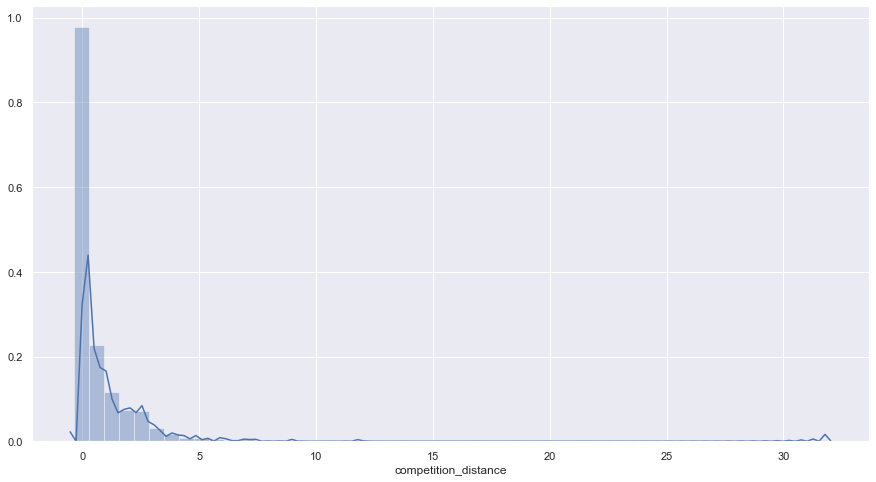

In [65]:
#verifico a nova escala de distancia de competidoroes
sns.distplot(df5['competition_distance'])

In [66]:
#ciclico

#day_of_week
#month
#day
#week of year

In [67]:
df5[['competition_distance']].values

array([[-0.17096774],
       [-0.28387097],
       [ 1.90322581],
       ...,
       [-0.24032258],
       [-0.14516129],
       [-0.25967742]])

### 5.3 Encoding das variaveis categoricas

In [71]:
#state_holiday ( One Hot Encoding)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type (Label Encoding)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment ( Ordinal Enconding)
assortment_dict = {
    'basic':1,
    'extra':2,
    'extended':3
}
df5['assortment'] = df5['assortment'].map(assortment_dict)